In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# Parâmetros
u0   = 4*np.pi*1e-9 #.. H/cm
urFe = 2500*u0 #....... H/cm
urAr =    1*u0 #....... H/cm
dx   = 1e-1 #............ cm
l    = 22 #.............. cm
h    = 20 #.............. cm
lbd  = 1.75 #     lambda, sobrerrelaxação
tol  = 1e-4 # tolerância, sobrerrelaxação

def gera_grid(dx, l, h):
    '''
    Função que cria, a partir das dimensões do espaço `l` e `h` e a partir da
    discretização deste espaço `dx` (=`dy`) um grid que o descreve
    
    Parameters
    ----------
    dx: float
        passo
    l: float
        largura do grid
    h: float
        altura do grid

    Returns
    -------
    M: int
        tamanho da grade em x
    N: int
        tamanho da grade em y
    X: np.ndarray, dim=(N, M)
        meshgrid em x
    Y: np.ndarray, dim=(N, M)
        meshgrid em y
    grid: np.ndarray, dim=(N, M)
        grid do sistema, inicialmente em branco
    '''
    # dimensões do grid
    M = int(l/dx) + 1
    N = int(h/dx) + 1

    # inicializando o grid
    grid = np.zeros((N, M))

    # criando dois vetores lineares x e y e os usando de base
    # para as matrizes X e Y, resultantes do meshgrid
    x = np.linspace(0, l, M)
    y = np.linspace(-h/2, h/2, N)
    X, Y = np.meshgrid(x, y)


    return M, N, X, Y, grid

def define_elementos(X, Y, grid):
    '''
    Função que toma o `grid`, gerado pelo método `gera_grid()` e o completa
    com a identificação dos elementos que o compõe cada qual em sua posição

    Parameters
    ----------
    X: np.ndarray, dim=(N, M)
        meshgrid em x
    Y: np.ndarray, dim=(N, M)
        meshgrid em y
    grid: np.ndarray, dim=(N, M)
        grid do sistema, inicialmente em branco

    Notes
    -----
    Para tornar o EP mais dinâmico e eficiente, decidiu-se criar apenas um
    grid composto por elementos infinitesimais que indicam o meio ao qual
    pertencem. Para tanto, utilizou-se a seguinte notação:
    - 0: pontos que não fazem parte do grid (resto que fica acima e abaixo
         da parte à direita da bobina, para preencher o espaço retangular)
    - 1: entreferro
    - 2: armadura
    - 3: núcleo de ferro
    - 4: bobina_LE
    - 5: bobina_LD
    - 6: interface armadura-entreferro
    - 7: interface núcleo de ferro-entreferro (cima, direção x)
    - 8: interface núcleo de ferro-entreferro (cima, direção y)
    - 9: interface núcleo de ferro-entreferro (baixo, direção x)
    -10: interface núcleo de ferro-entreferro (baixo, direção y)
    -11: interface entreferro-bobina_LE
    -12: interface bobina_LE-núcleo de ferro
    -13: interface núcleo de ferro-bobina_LD em x
    -14: interface núcleo de ferro-bobina_LD em y
    Com este método, todas as grandezas que dependem do meio podem facilmente
    ser definidas e, apenas com uma matriz, é possível descrever por exemplo
    a corrente Jz em todo o sistema (podemos filtrar os pontos em que temos
    a bobina e tornar todo o resto da matriz 0)
    '''
    # definindo as regiões dos diferentes elementos
    armadura = (X < 4)
    entreferro = np.logical_or(
        # primeiro retângulo, 
        # -10 <  y <  10
        #   4 <  X <   5
        np.logical_and(X > 4, X < 5),
        # região do meio,
        #  -6 <  y <   6
        #   5 <= x <  14
        np.logical_and(
            np.logical_and(X >= 5, X <= 14),
            np.logical_and(Y > -6, Y < 6)
            )
        )

    nucleo = np.logical_or(
        # pontas
        # y <= -6 | y >= 6
        # 5 <= x <  20
        np.logical_and(
            np.logical_and(X > 5, X < 20),
            np.logical_or(Y < -6, Y > 6)
            ),
        # barra vertical (entre as bobinas)
        # -10 <  y <  10
        #  16 <  x <  16
        np.logical_and(X > 16, X < 20)
        )

    bobina_LE =  np.logical_and(
        # bobina da esquerda (corrente entrando na folha)
        #  -6 <= y <=  6
        #  14 <= x <  16
        np.logical_and(X > 14, X < 16),
        np.logical_and(Y > -6, Y <  6)
        )
    
    bobina_LD = np.logical_and(
        # bobina da direita (corrente saindo da folha)
        #  -6 <= y <=  6
        #  20 <= x <  22
        np.logical_and(X > 20, X < 22),
        np.logical_and(Y > -6, Y <  6)
        )
    
    armadura_entreferro = X==4
    
    nucleo_entreferro_cima_x = np.logical_and(
            np.logical_and(
                X >= 5, X <= 14
            ), Y == 6
    )
    
    nucleo_entreferro_cima_y = np.logical_and(X == 5, Y >= 6)
    
    nucleo_entreferro_baixo_x = np.logical_and(
            np.logical_and(
                X >= 5, X <= 14
            ), Y == -6
    )
    
    nucleo_entreferro_baixo_y = np.logical_and(X == 5, Y <= -6)

    entreferro_bobina_LE = np.logical_and(
        X == 14,
        np.logical_and(
            Y >= -6, Y <= 6
        )
    )
        
    bobina_LE_nucleo_cima_x = np.logical_and(
            np.logical_and(
                X >= 14, X <= 16
            ),
                Y == 6
        )  
    
    bobina_LE_nucleo_baixo_x = np.logical_and(
            np.logical_and(
                X >= 14, X <= 16
            ),
                Y == -6
        )
    
    
    bobina_LE_nucleo_y = np.logical_and(
            X == 16,
            np.logical_and(
                Y >= -6, Y <= 6
            )
        )
    
    
    nucleo_bobina_LD = np.logical_and(
        X == 20,
        np.logical_and(
            Y >= -6, Y <= 6
        )
    )

    # assignando os códigos de cada região (regiões não assignadas não fazem
    # parte do sistema, região externa, continuam em 0)
    grid[entreferro]    = 1
    grid[armadura]      = 2
    grid[nucleo]        = 3
    grid[bobina_LE]     = 4
    grid[bobina_LD]     = 5
    grid[armadura_entreferro]  = 6
    grid[nucleo_entreferro_cima_x]  = 7
    grid[nucleo_entreferro_cima_y]  = 8
    grid[nucleo_entreferro_baixo_x] = 9
    grid[nucleo_entreferro_baixo_y] = 10
    grid[entreferro_bobina_LE] = 11
    grid[bobina_LE_nucleo_cima_x]   = 12
    grid[bobina_LE_nucleo_baixo_x]  = 13
    grid[bobina_LE_nucleo_y]  = 14
    grid[nucleo_bobina_LD]     = 15
    
    return grid

M, N, X, Y, grid = gera_grid(dx, l, h)
grid = define_elementos(X, Y, grid)
A = np.zeros((N, M))

def calcula_J(y):
    '''
    Função auxiliar que calcula a corrente dado um ponto y
    '''
    return 2e6*np.cos(np.pi*y/12) + 8e5

for j in range(1, N-1):
    for i in range(1, M-1):
        if grid[j, i] == 0:
            A[j, i] = 0
        elif grid[j, i] in [1, 2, 3]:
            A[j, i] = 1/4 * (A[j+1, i] 
                           + A[j-1, i]
                           + A[j, i-1]
                           + A[j, i+1])
        elif grid[j, i] == 4:
            y = Y[j, 0]
            A[j, i] = 1/4 * (A[j+1, i] 
                           + A[j-1, i]
                           + A[j, i-1]
                           + A[j, i+1]
                           + dx**2*urAr*calcula_J(y))
        # na bobina e na interface entreferro-bobina
        elif grid[j, i] in [5, 11]:
            y = Y[j, 0]
            A[j, i] = 1/4 * (A[j+1, i] 
                           + A[j-1, i]
                           + A[j, i-1]
                           + A[j, i+1]
                           - dx**2*urAr*calcula_J(y))
        elif grid[j, i] == 6:
            uAntes  = urFe
            uDepois = urAr
            A[j, i] = (1/4 * 1/(1 + uDepois/uAntes)
                       *(
                           (1 + uDepois/uAntes)*(A[j+1, i] + A[j-1, i])
                        + 2*(A[j, i+1] + uDepois/uAntes * A[j, i-1])
                       )
                      )
            
        elif grid[j, i] in [7, 9, 12]:
            uAntes  = urAr
            uDepois = urFe
            A[j, i] = (1/4 * 1/(1 + uDepois/uAntes)
                       *(
                           (1 + uDepois/uAntes)*(A[j, i+1] + A[j, i-1])
                        + 2*(A[j+1, i] + uDepois/uAntes * A[j-1, i])
                       )
                      )
            
        elif grid[j, i] == 8:
            uAntes  = urFe
            uDepois = urAr
            A[j, i] = (1/4 * 1/(1 + uDepois/uAntes)
                       *(
                           (1 + uDepois/uAntes)*(A[j+1, i] + A[j-1, i])
                        + 2*(A[j, i+1] + uDepois/uAntes * A[j, i-1])
                       )
                      )
            
        elif grid[j, i] == 10:
            uAntes  = urAr
            uDepois = urFe
            A[j, i] = (1/4 * 1/(1 + uDepois/uAntes)
                       *(
                           (1 + uDepois/uAntes)*(A[j+1, i] + A[j-1, i])
                        + 2*(A[j, i+1] + uDepois/uAntes * A[j, i-1])
                       )
                      )
            
        elif grid[j, i] == 12:
            uAntes  = urAr
            uDepois = urFe
            

NameError: name 'urAe' is not defined

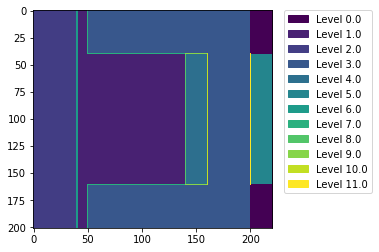

In [37]:
M, N, X, Y, grid = gera_grid(dx, l, h)
grid = define_elementos(X, Y, grid)


import matplotlib.patches as mpatches
values = np.unique(grid.ravel())

plt.figure(figsize=(8,4))
im = plt.imshow(grid, interpolation='none')
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()
#plt.imshow(grid, origin='lower', interpolation="none")
